# Speculative Decoding

<a target="_blank" href="https://colab.research.google.com/github/yandexdataschool/nlp_course/blob/2024/week10_efficiency/hw_speculative.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
!pip install triton
!pip install datasets
# !pip install unsloth

### Greedy Generation Baseline

**Load the model**

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

LLAMA_REPO = "unsloth/Llama-3.2-3B"
model = AutoModelForCausalLM.from_pretrained(LLAMA_REPO, torch_dtype=torch.float16, device_map="cuda")
model.generation_config.pad_token_id = 128001

tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


**Compile model forward for more accurate benchmarks**

`transformers` is not a very efficient inference engine because of high python overhead and almost no kernel optimization.

However, with `PyTorch` `v2.0.0`, [`torch.compile`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) was introduced. This feature allows for capturing, isolating and optimizing CUDA runtime in `PyTorch`. Using this feature, we can effectively eliminate almost all python overhead and optimize the kernels.

Starting with [`transformers` `v4.44.0`](https://github.com/huggingface/transformers/releases/tag/v4.44.0), this feature is integrated with `transformers` text generation utils end-to-end. However, for simplicity, we'll apply it to the forward pass of the model specifically.

In [2]:
model.forward = torch.compile(
    model.forward,          # the function call to compile
    fullgraph=True,         # Compile all the CUDA kernels into a single entity
    mode="reduce-overhead", # Optimize for speed
)

**Benchmark forward passes with different seq_len**

Run the following cell 2+ times. The first time is slow because that's when the compilation is taking place.

The following runs are much faster.

(EXTRA: run this cell without compiling to measure scompilation speedup)

In [5]:
from time import perf_counter

NUM_REPEATS = 100

throughpus = {}

for seq_len in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    input_ids = torch.randint(0, tokenizer.vocab_size, (1, seq_len)).to("cuda")

    with torch.no_grad():
        start = perf_counter()
        for _ in range(NUM_REPEATS):
            model(
                input_ids,
                use_cache=False,
            )
            torch.cuda.synchronize()
        end = perf_counter()
    throughpus[seq_len] = NUM_REPEATS * seq_len / (end - start)
    print(f"{seq_len} tokens: {NUM_REPEATS / (end - start):.2f} passes/s")

1 tokens: 46.33 passes/s
2 tokens: 53.75 passes/s
4 tokens: 53.60 passes/s
8 tokens: 53.09 passes/s
16 tokens: 52.46 passes/s
32 tokens: 50.67 passes/s
64 tokens: 48.91 passes/s
128 tokens: 37.42 passes/s
256 tokens: 23.38 passes/s
512 tokens: 11.42 passes/s
1024 tokens: 5.25 passes/s


As we can see, the forward pass speed almost doesn't depend on the number of tokens passed through the model up to around **16** tokens at a time.

Text(0, 0.5, 'Troughput, tokens per second')

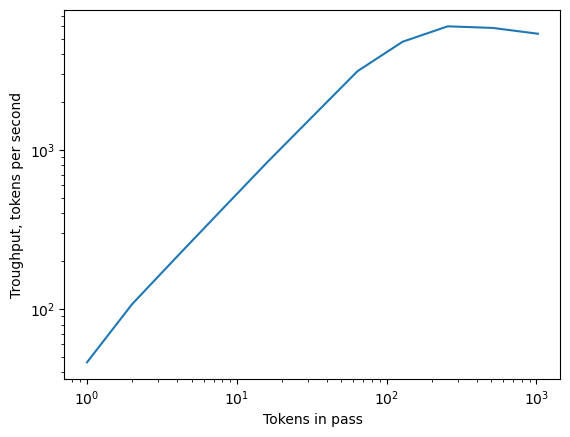

In [ ]:
import matplotlib.pyplot as plt

plt.plot(throughpus.keys(), throughpus.values())
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Tokens in pass")
plt.ylabel("Troughput, tokens per second")

In [9]:
del model
model = AutoModelForCausalLM.from_pretrained(LLAMA_REPO, torch_dtype=torch.float16, device_map="cuda")

## Speculative Decoding

As a baseline, we'll generate hypotheses using a very simple bigram model.

### Load the Data

We'll use the [wikitext2](https://paperswithcode.com/dataset/wikitext-2) dataset as a sample of natural language.

In [3]:
import random

from datasets import load_dataset

SEED = 0

def get_wikitext2(seed, seqlen, nsamples=64):
    traindata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

    tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO, use_fast=False)

    train_input_ids = tokenizer("\n\n".join(traindata['text']), return_tensors='pt').input_ids
    random.seed(seed)
    train_batch = []
    for _ in range(nsamples):
        i = random.randint(0, train_input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = train_input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        train_batch.append(inp[0])

    test_input_ids = tokenizer("\n\n".join(testdata['text']), return_tensors='pt').input_ids
    test_input_ids = test_input_ids[:, :(test_input_ids.shape[1] // seqlen) *  seqlen]
    test_input_ids = test_input_ids.reshape(test_input_ids.shape[1] // seqlen, seqlen)

    return torch.stack(train_batch), test_input_ids

train_batch, test_input_ids = get_wikitext2(SEED, 8192)

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


**Task (0.5pt points):** Build a bigram model

Using sequences from `train_batch`, build a bigram model for predicting `n` tokens into the future.

In [4]:
from tqdm.auto import tqdm, trange

from typing import Mapping


import numpy as np
from collections import Counter, defaultdict


def build_next_token_array(
    train_data, vocab_size: int = 128256, default_next_token: int = 220
) -> Mapping[int, int]:
    """
    Builds an array mapping each token in the vocabulary to its most likely next token based on training data.

    Args:
        train_data (np.ndarray): Array of training data tokens.
        vocab_size (int): The size of the vocabulary.
        default_next_token (int): Default token to use if no next token can be determined.

    Returns:
        Mapping[int, int]: Array where each index represents a token and the value at that index is the most likely next token.
    """
    count = defaultdict(lambda: Counter())

    for token, next_token in zip(train_data, train_data[1:]):
        count[token.item()][next_token.item()] += 1
    # return count

    # next_tokens_array = count
    next_tokens_array = {
        token: (
            count[token].most_common(1)[0][0]
            if token in count
            else default_next_token
        )
        for token in range(vocab_size)
    }

    return next_tokens_array


def speculate_bigram(
    input_ids: torch.Tensor, position: int, n: int, next_tokens_array: Mapping[int, int]
) -> int:
    """
    Generates a speculative sequence by predicting next tokens in a sequence using a bigram model.

    Args:
        input_ids (torch.Tensor): Tensor of input token IDs.
        position (int): Position in the sequence to begin speculation.
        n (int): Number of tokens to generate.
        next_tokens_array (Mapping[int, int]): Mapping of tokens to their most likely next token.

    Returns:
        int: Number of tokens generated.
    """
    for i in range(n):
        hypo_next_token = next_tokens_array[input_ids[0, position - 1].item()]
        input_ids[0, position] = hypo_next_token
        position += 1

    return n


NEXT_TOKEN_WIKI2 = build_next_token_array(train_batch.flatten())

**Task (1.5 points)** Implement greedy sequential speculative decoding:

You're given a prototype of the function that generate a token sequence greedily by speculating `n` tokens into the fulure and verifying those tokens.

Your task is to:
 * Correctly fill a hypothesis inplace (using `speculate_fn`)
 * Pass the hypothesis through the model (with correct `past_key_values`)
 * Find where the hypothesis diverges.
 * Update the current position in the generation, as well as the number of forward pass calls.

In [5]:
from transformers import StaticCache


def truncate_past_key_values(past_key_values, position):
    """
    Truncates the past key and value caches at a specific position. `transformers`-specific stuff. Might change with their next update.

    Args:
        past_key_values (object): Object containing key and value caches for each layer.
        position (int): Position from which to truncate the caches.
    """
    for layer_idx in range(len(past_key_values.key_cache)):
        past_key_values.key_cache[layer_idx][:, :, position - 1 :] = 0.0
        past_key_values.value_cache[layer_idx][:, :, position - 1 :] = 0.0


def generate_speculative(
    model,
    tokenizer,
    num_tokens_to_generate: int,
    speculate_fn: callable,
    max_speculated_len: int = 128,
    initial_prompt: str = "The Pacific",
    verbose: bool = False,
):
    """
    Generates text using speculative decoding, a technique that combines conventional forward passes with speculative predictions to reduce computation by hypothesizing multiple tokens at each step.

    Args:
        model (transformers.PreTrainedModel): The language model used to generate text.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer corresponding to the model for encoding and decoding text.
        num_tokens_to_generate (int): The number of tokens to generate in total.
        speculate_fn (callable): A function that generates speculative tokens based on the input IDs and current position.
            This function takes `input_ids` and `position` as arguments and returns the number of tokens speculated.
        max_speculated_len (int, optional): The maximum length of speculative tokens allowed in a single step. Defaults to 128.
        initial_prompt (str, optional): The starting prompt for text generation. Defaults to "The Pacific".
        verbose (bool, optional): If True, prints debugging information about successful speculative predictions. Defaults to False.

    Returns:
        torch.Tensor: The generated sequence of input IDs up to the generated position.
        int: The number of forward passes required for generation, which can be used to assess efficiency.

    Example:
        >>> output, forward_passes = generate_speculative(
        ...     model,
        ...     tokenizer,
        ...     num_tokens_to_generate=100,
        ...     speculate_fn=lambda input_ids, position: fill_hypothesis(input_ids, position, n=2, next_tokens_array=next_tokens_array),
        ...     verbose=True
        ... )
        >>> print("Generated Text:", tokenizer.decode(output))
        >>> print("Tokens per forward pass:", 100 / forward_passes)

    Notes:
        - Speculative decoding reduces the number of model passes by hypothesizing tokens using the `speculate_fn` function. The actual model output is used to verify these hypotheses, allowing efficient token generation.
        - If verbose mode is enabled, it will display speculative matches as they occur.
    """

    # Encode the initial prompt and get input IDs, then move them to the GPU
    prompt_ids = tokenizer(
        initial_prompt, return_tensors="pt", truncation=True
    ).input_ids.to("cuda")
    position = prompt_ids.shape[1]  # Initial position for the prompt

    # Calculate the maximum cache length to accommodate generated tokens and speculative tokens
    max_cache_len = num_tokens_to_generate + position + max_speculated_len
    # Initialize the cache for past key values with model configuration, setting cache size and device
    past_key_values = StaticCache(
        config=model.config,
        max_batch_size=1,
        max_cache_len=max_cache_len,
        device="cuda",
        dtype=torch.float16,
    )
    # Allocate space for input IDs and cache positions on the GPU
    input_ids = torch.zeros((1, max_cache_len), device="cuda", dtype=torch.long)
    # Fill in the initial prompt
    input_ids[0, :position] = prompt_ids[0, :position]

    with torch.no_grad():  # Disable gradients for inference
        # Pre-fill cache with the prompt to start the model's internal state
        past_key_values = model(
            input_ids[:, :position], past_key_values=past_key_values
        ).past_key_values

        forward_passes = 0  # Track number of forward passes
        tokens_generated = 0  # Track number of tokens generated
        while tokens_generated < num_tokens_to_generate:
            # Adjust cache by removing outdated values to avoid memory overflow
            truncate_past_key_values(past_key_values, position)

            # Speculate the next few tokens based on current position
            num_tokens_speculated = speculate_fn(
                input_ids, position
            )  # Number of tokens hypothesized
            # YOUR CODE HERE>>>>>>>>>
            output = model(
                input_ids[:, position - 1 : position + num_tokens_speculated],
                past_key_values=past_key_values,
            )
            # <<<<<<<<<<<<<<<<<<<<<<<
            past_key_values = (
                output.past_key_values
            )  # Update the cache with new predictions

            # Extract predicted tokens and the speculative tokens for comparison
            # YOUR CODE HERE>>>>>>>>>
            real_tokens = output.logits[0].argmax(dim=-1)
            hypothesis_tokens = input_ids[
                0, position : position + num_tokens_speculated
            ]

            # return output, input_ids, position, num_tokens_speculated

            match_len = torch.nonzero(
                real_tokens[:-1] != hypothesis_tokens, as_tuple=True
            )[0]
            match_len = (
                match_len[0].item() if len(match_len) > 0 else len(hypothesis_tokens)
            )
            # <<<<<<<<<<<<<<<<<<<<<<<

            # Optionally, print successful speculative predictions
            if verbose and match_len > 0:
                print(
                    f"HIT: '{tokenizer.decode(input_ids[0, position-1])}'->'{tokenizer.decode(real_tokens[:match_len])}'"
                )

            # Copy matched tokens to the input IDs array
            # YOUR CODE HERE>>>>>>>>>

            input_ids[0, position : position + match_len + 1] = real_tokens[
                : match_len + 1
            ]
            # <<<<<<<<<<<<<<<<<<<<<<<

            # Update the position, tokens generated count, and forward passes
            # YOUR CODE HERE>>>>>>>>>
            position += match_len + 1
            forward_passes += 1
            tokens_generated += match_len + 1
            # <<<<<<<<<<<<<<<<<<<<<<<
    return input_ids[0, :position], forward_passes


NUM_TOKENS_TO_GENERATE = 100

# Call the function with parameters and lambda function for speculative decoding
max_speculated_len = 128


output, forward_passes = generate_speculative(
    model,
    tokenizer,
    NUM_TOKENS_TO_GENERATE,
    # YOUR CODE HERE>>>>>>>>>
    speculate_fn=lambda input_ids, position: speculate_bigram(
        input_ids, position, 30, NEXT_TOKEN_WIKI2
    ),
    max_speculated_len=max_speculated_len,
    # <<<<<<<<<<<<<<<<<<<<<<<
    verbose=True,
)

# Display metrics and the decoded output
print(f"Tokens per forward pass: {NUM_TOKENS_TO_GENERATE / forward_passes}\n")
print(tokenizer.decode(output))

The 'max_batch_size' argument of StaticCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.


HIT: ' is'->' a'
HIT: ' region'->' of the'
HIT: ' United'->' States'
HIT: ' home'->' to'
HIT: ' number'->' of'
HIT: ' some'->' of the'
HIT: ' in'->' the'
HIT: ' is'->' a'
HIT: ' destination'->' for'
HIT: ' interested'->' in'
HIT: ' home'->' to the'
Tokens per forward pass: 1.1627906976744187

<|begin_of_text|>The Pacific Northwest is a region of the United States that is known for its natural beauty, diverse landscapes, and rich cultural heritage. The region is home to a number of unique and interesting places that are worth visiting. In this article, we will explore some of the best places to visit in the Pacific Northwest.
1. Mount Rainier National Park: Located in Washington state, Mount Rainier National Park is a must-visit destination for anyone interested in natural beauty. The park is home to the tallest mountain in


In [5]:
output0, n0 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 0, NEXT_TOKEN_WIKI2), verbose=False)
output1, n1 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 1, NEXT_TOKEN_WIKI2), verbose=False)
output2, n2 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 2, NEXT_TOKEN_WIKI2), verbose=False)
output4, n4 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 4, NEXT_TOKEN_WIKI2), verbose=False)

try:
    assert n0 == NUM_TOKENS_TO_GENERATE, "Model that doesnt' speculate does exatcly one forward pass per token"
    assert n4 <= n2 and n2 <= n1 and n1 < n0, "It's very unlikely that the performance decreases with stronger speculation"
    assert (output1 == output0).all(), "The outputs don't match"
    print("All tests passed")
except AssertionError as e:
    print("Error occured. Generated texts:\n")
    print(*tokenizer.batch_decode([output0, output1, output2, output4]), sep="\n", end="\n\n")
    raise e

All tests passed


As we have shown, we can increase the hypotheses length up to `16` at almost no inference cost.

Let's see how much it actually helps:

In [6]:
for speculate_length in [0, 1, 2, 3, 4, 5, 6]:
    _, num_passes = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, speculate_length, NEXT_TOKEN_WIKI2), verbose=False)
    print(f"Speculate length {speculate_length}: {NUM_TOKENS_TO_GENERATE / num_passes:.2f} tokens per forward pass")

Speculate length 0: 1.00 tokens per forward pass
Speculate length 1: 1.14 tokens per forward pass
Speculate length 2: 1.16 tokens per forward pass
Speculate length 3: 1.16 tokens per forward pass
Speculate length 4: 1.16 tokens per forward pass
Speculate length 5: 1.16 tokens per forward pass
Speculate length 6: 1.16 tokens per forward pass


It appears the bigram model doesn't improve above `2`. That is because it's very unlikely that a bigram model outputs a long meaningful sequence.

We need a stronger model.

<span style="color:Red">SEMINAR ENDS HERE HOPEFULLY</span>

## Stronger Model

**Task (2.0+ points)** Use a stronger model for speculative decoding:

The `generate_speculative` function can take any callable inplace of `speculate_fn`. You have many options as what can be used here:
 * **Larger N-gram models**: use larger n and more data to fit it.
 * **A tiny Llama model**: the problem with using an LLM as a speculative generator is that it has to share tokenizer with the verifier model. That is, your tiny llama has to have the same tokenizer.
   * Make sure to properly store and reuse `past_key_values` for it.
   * Verify that the model forward pass is really negligible in terms of hypothesis generation time (time verify >> time speculate)
 * **An LSTM**: Train it from scratch. You might initialize the embedding layer with the llama embeddings for easier convergence.
 * **word2vec/CBOW**: Train it on the `train_batch` or anything else you want. Make sure that it only uses past tokens and that the context is longer than what you want to speculate.
 * **Wide Speculation**: Your hypothesis doesn't have to be linear. You can actually speculate a tree of possible next tokens and verify it with a single pass. That requires some nontrivial `attention_mask` manipulations, however. Read more [here](https://arxiv.org/abs/2305.09781) and [here](https://huggingface.co/blog/poedator/4d-masks).

*The amount of points to be received here depends on how complex your solution is and what token acceptance rate per forward pass of the verifier it achieves. Achieving accepting 2+ tokens per forward pass on average guarantees at leas 2 points.*

***I tried training a small LSTM, but even with initialized embeddings, the model turned out to be too weak (a failed attempt in the end). So, I decided to use a hack. I will use DistilGPT-2 (around 80 million parameters). Since the tokenizers for the LSTM and DistilGPT-2 use different tokens, I will need to transform tokens between the two at every step. This will add some overhead, but it should still provide a speed-up overall.***

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "distilgpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name).to('cuda')

In [6]:
import time


def speculate_gpt2(input_ids: torch.Tensor, position: int, n: int) -> int:
    if n == 0:
        return 0

    # this can be done more efficiently, but i'm too lazy
    text = tokenizer.decode(input_ids[0, 1:position])
    gpt2_ids = gpt2_tokenizer.encode(text, return_tensors="pt").to("cuda")

    generated = gpt2_model.generate(
        gpt2_ids,
        max_length=n + gpt2_ids.shape[1],
        num_return_sequences=1,
        pad_token_id=gpt2_tokenizer.eos_token_id,
    )
    generated_ids = tokenizer.encode(
        gpt2_tokenizer.decode(
            generated[0, gpt2_ids.shape[1] :], skip_special_tokens=True
        ),
        return_tensors="pt",
    )[0, 1:]

    can_add = min(len(generated_ids), len(input_ids[0]) - position)
    input_ids[0, position : position + can_add] = generated_ids[:can_add]

    return can_add

In [20]:
UM_TOKENS_TO_GENERATE = 100
max_speculated_len = 5

output, forward_passes = generate_speculative(
    model,
    tokenizer,
    NUM_TOKENS_TO_GENERATE,
    speculate_fn=lambda input_ids, position: speculate_gpt2(input_ids, position, 3),
    max_speculated_len=max_speculated_len,
    verbose=True,
)

# Display metrics and the decoded output
print(f"Tokens per forward pass: {NUM_TOKENS_TO_GENERATE / forward_passes}\n")
print(tokenizer.decode(output))

HIT: ' Pacific'->' Northwest is'
HIT: ' region'->' of the'
HIT: ' United'->' States that'
HIT: ' known'->' for its'
HIT: ' beauty'->','
HIT: ' landscapes'->', and'
HIT: ' cultural'->' heritage'
HIT: ' region'->' is home to'
HIT: ' number'->' of'
HIT: ' unique'->' and'
HIT: ' that'->' are'
HIT: ' this'->' article, we'
HIT: ' will'->' explore'
HIT: ' some'->' of the'
HIT: ' best'->' places to visit'
HIT: ' in'->' the Pacific Northwest'
HIT: '1'->'.'
HIT: ' Mount'->' Rainier'
HIT: ' National'->' Park'
HIT: ' Located'->' in'
HIT: ' state'->', Mount Rain'
HIT: 'ier'->' National Park is'
HIT: ' must'->'-visit'
HIT: ' destination'->' for anyone'
HIT: ' interested'->' in'
HIT: ' outdoor'->' activities.'
HIT: ' The'->' park is'
HIT: ' home'->' to'
Tokens per forward pass: 2.0408163265306123

<|begin_of_text|>The Pacific Northwest is a region of the United States that is known for its natural beauty, diverse landscapes, and rich cultural heritage. The region is home to a number of unique and int

In [21]:
%%timeit
UM_TOKENS_TO_GENERATE = 100
max_speculated_len = 5

output, forward_passes = generate_speculative(
    model,
    tokenizer,
    NUM_TOKENS_TO_GENERATE,
    speculate_fn=lambda input_ids, position: speculate_gpt2(input_ids, position, 3),
    max_speculated_len=max_speculated_len,
    verbose=False,
)

5.68 s ± 1.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
UM_TOKENS_TO_GENERATE = 100
max_speculated_len = 5

output, forward_passes = generate_speculative(
    model,
    tokenizer,
    NUM_TOKENS_TO_GENERATE,
    speculate_fn=lambda input_ids, position: speculate_gpt2(input_ids, position, 0),
    max_speculated_len=max_speculated_len,
    verbose=False,
)

9.52 s ± 380 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


***Failed LSTM***

In [ ]:
import torch.nn as nn


class SimpleSpeculator(nn.Module):
    def __init__(self, embeddings, hid_size=64,num_layers=1):
        super().__init__()

        vocab_size = embeddings.weight.shape[0]

        self.emb = nn.Embedding.from_pretrained(
            embeddings.weight.to(torch.float32), freeze=True
        )
        self.rnn = nn.LSTM(
            embeddings.weight.shape[1], hid_size, batch_first=True, num_layers=num_layers
        )
        self.hid_to_logits = nn.Linear(hid_size, vocab_size)

    def forward(self, input_ix, hidden=None):
        X = self.emb(input_ix.to("cuda"))
        X, hidden = self.rnn(X, hidden)
        X = self.hid_to_logits(X)

        return X, hidden

    def greedy_generate(self, input_ids, position, speculate_len):
        assert input_ids.shape[0] == 1
        assert input_ids.shape[1] >= position

        logits, hidden = self(input_ids[:, :position], None)
        with torch.no_grad():
            for i in range(speculate_len):
                next_token = logits[0][-1].argmax(dim=-1)
                input_ids[0, position] = next_token
                position += 1

                logits, hidden = self(input_ids[:, position - 1 : position], hidden)

        return speculate_len

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


sequence_length = 32


class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


X = train_batch.flatten().reshape(-1, sequence_length)
Y = train_batch.flatten().roll(-1)
Y[-1] = 220
Y = Y.reshape(-1, sequence_length)
dataset = TextDataset(X, Y)



X_test = test_input_ids[:5].flatten().reshape(-1, sequence_length)
Y_test = test_input_ids[:5].flatten().roll(-1)
Y_test[-1] = 220
Y_test = Y_test.reshape(-1, sequence_length)
dataset_test = TextDataset(X_test, Y_test)

In [16]:
from tqdm.auto import tqdm

simple_model = SimpleSpeculator(model.model.embed_tokens, 512, 3).to("cuda")
optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


losses = []
test_losses = []
for epoch in range(40):
    simple_model.train()
    for X, Y in tqdm(dataloader):
        X = X.to("cuda")
        Y = Y.to("cuda")
        optimizer.zero_grad()
        outputs, _ = simple_model(X)
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), Y.reshape(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    simple_model.eval()
    total_test_loss = 0.0
    num_test_samples = 0

    with torch.no_grad():
        for X_test, Y_test in tqdm(dataloader_test):
            X_test = X_test.to("cuda")
            Y_test = Y_test.to("cuda")
            outputs_test, _ = simple_model(X_test)
            test_loss = criterion(
                outputs_test.reshape(-1, outputs_test.shape[-1]), Y_test.reshape(-1)
            )
            total_test_loss += test_loss.item() * X_test.size(0)
            num_test_samples += X_test.size(0)

    avg_test_loss = total_test_loss / num_test_samples
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss}")

  0%|          | 0/2048 [00:00<?, ?it/s]

KeyboardInterrupt: 

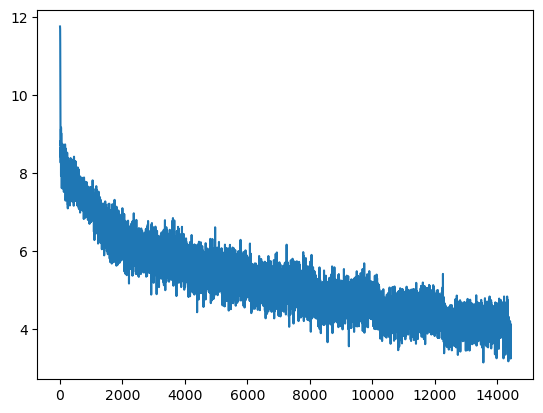

In [6]:
from matplotlib import pyplot as plt

plt.plot(losses)

In [ ]:
super_duper_speculator = lambda input_ids, position: simple_model.greedy_generate(input_ids, position, speculate_len=10)


NUM_TOKENS_TO_GENERATE = 100

output, forward_passes = generate_speculative(
    model,
    tokenizer,
    NUM_TOKENS_TO_GENERATE,
    speculate_fn=super_duper_speculator,
    verbose=True)

# Display metrics and the decoded output
print(f"Tokens per forward pass: {NUM_TOKENS_TO_GENERATE / forward_passes}\n")
print(tokenizer.decode(output))

if NUM_TOKENS_TO_GENERATE / forward_passes >= 2.0:
    print("Great Success!")

HIT: ' region'->' of the'
HIT: ' United'->' States'
HIT: ' home'->' to'
HIT: ' number'->' of'
HIT: ' that'->' are'
HIT: ' some'->' of the'
HIT: ' in'->' the'
HIT: ' Located'->' in'
HIT: ' is'->' a'
HIT: ' interested'->' in'
HIT: ' home'->' to'
Tokens per forward pass: 1.1494252873563218

<|begin_of_text|>The Pacific Northwest is a region of the United States that is known for its natural beauty, diverse landscapes, and rich cultural heritage. The region is home to a number of unique and interesting places that are worth visiting. In this article, we will explore some of the best places to visit in the Pacific Northwest.
1. Mount Rainier National Park: Located in Washington state, Mount Rainier National Park is a must-visit destination for anyone interested in natural beauty and outdoor activities. The park is home to the
